# Implementing Machine Learning Ensembles of Decision Trees in Python

> A manual implementation of the <a href="https://en.wikipedia.org/wiki/Random_forest">Random Forest</a> and <a href="https://en.wikipedia.org/wiki/Gradient_boosting">Gradient Boosting</a> algorithms (for <a href="https://en.wikipedia.org/wiki/Classification">classification</a> and <a href="https://en.wikipedia.org/wiki/Regression">regression</a> problems respectively) in <a href="https://en.wikipedia.org/wiki/Machine_learning">machine learning</a>.
- toc: true
- badges: true
- comments: true
- sticky_rank: 1
- categories: [random-forest, gradient-boosting, ml-algorithm-from-scratch, machine-learning, python]

In [1]:
#hide
from collections import Counter
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.ticker import FuncFormatter
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.datasets import make_classification, make_regression
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [2]:
#hide
sns.set_context("talk")
sns.set_palette("bright")

## Background

In this post, we will implement two popular tree-based machine learning (ML) algorithms from scratch. Usually, such approaches can improve the accuracy of predictions made with a single ML model by combining these predictions. There are several flavours of ensembling techniques that are used in ML. Here, we will focus on two of them - [bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating) (or bootstrapping) and [boosting](https://en.wikipedia.org/wiki/Boosting_(machine_learning)).

## Goal

Here, we will use Python to implement these two ensemble algorithms from scratch - random forest for ML (binary) classification and gradient boosting for ML regression tasks. Both ensembling techniques use tree-based algorithms. We'll use each implemented ensemble with a synthetic dataset. They will be trained and used to make predictions that will be scored on data that was not used during training. These scores will be compared to the corresponding scores from each algorithm's implementations provided by the `scikit-learn` library in Python. If our implementation has correctly captured the ensembling logic, then our manual approaches should agree with the versions provided by `scikit-learn`.

The focus here will on implementing the ensembles. To stay within scope, we'll use the individual decision tree ML models provided by `scikit-learn` and won't implement a single decision tree from scratch.

## Overview of Random Forest

The main principle behind the random forest algorithm is that multiple decision trees will be trained on separate (random) subsets of the training data. Each of these tree is then used to make a prediction. For classification, the most commonly occurring of these predictions will be chosen.

An overview of the working of this algorithm is as follows
1. Draw a bootstrap sample of the training data
2. Train a single decision tree on this random sample
3. Use the trained decision tree to make a prediction on unseen (test) data
4. Repeat the above three steps for as many individual decision trees that we want.
5. Among all the predicted classes made by all decision trees in step 4., choose the most commonly occurring ones and return these as the final prediction for the observations in the unseen data.

## Manual Implementation of Random Forest

We'll begin the implementatoin of this algorithm by creating a class with the following parameters that will be passed to the individual decision trees that we will train
- `min_samples_split`
  - the minimum samples required for a split
- `max_depth`
- `num_features`

This is not the full set of hyper-parameters that can be passed to a single decision tree. More can be added later if required.

All these parameters will be passed to the `__init__` method of this class. We are also inheriting from the `BaseEstimator` and `RegressorMixin` classes so that this class is compatible with the `scikit-learn` API.

As mentioned earlier, a list of decision trees will be built during training and be called upon to make predictions. We'll instantiate this list in the `__init__` of this class so it can be used in the other methods of this class.

```python
class CustomRandomForestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, min_samples_split=5, max_depth=25, num_features=None, num_trees=50):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_features = num_features
        self.num_trees = num_trees
        
        self.trees = []
```

The fit method will start by iterating over our specified range of trees specified as the `num_trees` parameter. We'll pass the parameters defined in the `__init__` method that are required by a single decision tree. Here, these will be `min_samples_split`, `max_depth` and `num_features`.

Then, we will train this tree on a random bootstrap sample of the training data. We'll extract this sample using a helper function `draw_bootstrap_sample()`. This function will randomly select from zero to all the available training observations. We will draw samples with replacement, [meaning](https://www.educba.com/numpy-random-choice/) we will randomly drop some training observations and replace them with duplicates of the other (randomly selected) observations.

Each decision tree will be trained on this sample of the data passed to it and the trained tree will be appended to the empty list we instantiated earlier in `__init__`.

```python
def draw_bootstrap_sample(X, y):
    num_samples = len(X)
    random_indexes = np.random.choice(num_samples, num_samples, replace=True)
    X_sample, y_sample = X[random_indexes], y[random_indexes]
    return X_sample, y_sample


@staticmethod
def train_bootstrap_sample(min_samples_split, max_depth, num_features):
    clf = DecisionTree(
        min_samples_split=min_samples_split,
        max_depth=max_depth,
        n_feats=num_features,
    )
    X_sampled, y_sampled = draw_bootstrap_sample(X, y)
    clf.fit(X_sampled, y_sampled)
    return clf


def fit(self, X, y):
    self.trees = [
        train_bootstrap_sample(
            self.min_samples_split,
            self.max_depth,
            self.num_features,
        )
        for _ in range(self.num_trees)
    ]
```

where `train_bootstrap_sample()` is a static method ([1](https://www.programiz.com/python-programming/methods/built-in/staticmethod), [2](https://docs.python.org/3/library/functions.html#staticmethod)) for our `CustomRandomForestClassifier` class.

The predictions will iterate over the list of trained decision trees and use each of them to make predictions. We'll store these predictions (slices of the training data) in an array.

Each element of this array is the prediction of a slice of the training data. We'll reshape this array such that all predictions of the first sample are immediately ahead of all predictions of the second sample which in-turn are immediately ahead of all predictions of the third sample, and so on. This way, we can extract the most common prediction of the each sample by iterating over this reshaped array and picking the most commonly occurring element (prediction) during each iteration. The `numpy` library's `.swapaxes()` method does this for us. There are other ways to extract the most commonly occurring prediction from the array of predictions, so this approach is only for convenience.

Finally, we'll append all of the most common predictions to a separate blank list, which we'll convert to an array and return as the final predictions of the ensemble algorithm.

```python
def predict(self, X):
    # use each trained decition tree to make a prediction
    y_preds = np.array([clf.predict(X) for clf in self.trees])

    # reshaping (for convenience)
    y_preds = np.swapaxes(y_preds, 0, 1)

    # return the most commonly predicted class label across
    # predictions by all trees
    y_pred_list = []
    for y_pred in y_preds:
        if not self.threshold:
            # without using probabilities
            y_pred_single = Counter(y_pred).most_common(1)[0][0]
        else:
            # using probabilities
            y_pred_single = use_probabilities_to_get_labels(y_pred, 0.5)
        y_pred_list.append(y_pred_single)
    y_pred = np.array(y_pred_list)
    return y_pred
```

The final complete class to realize this implementation is shown below

In [3]:
def draw_bootstrap_sample(X_full, y_full):
    num_samples = len(X_full)
    random_indexes = np.random.choice(num_samples, num_samples, replace=True)
    X_sample, y_sample = X_full[random_indexes], y_full[random_indexes]
    return X_sample, y_sample


def use_probabilities_to_get_labels(y_train_labels, threshold=0.5):
    # get average of training labels
    y_pred_proba = np.mean(y_train_labels)
    # assign test labels by comparing average label value to threshold
    y_pred = 0 if y_pred_proba < threshold else 1
    return y_pred

In [4]:
class CustomRandomForestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        min_samples_split=5,
        max_depth=25,
        num_features=None,
        num_trees=50,
        threshold=None,
    ):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_features = num_features
        self.num_trees = num_trees
        self.threshold = threshold
        
        self.trained_decision_trees = []


    @staticmethod
    def train_bootstrap_sample(X, y, min_samples_split, max_depth, num_features):
        tree_ = DecisionTreeClassifier(
            min_samples_split=min_samples_split,
            max_depth=max_depth,
            max_features=num_features,
        )

        # Draw bootstrap sample
        X_sampled, y_sampled = draw_bootstrap_sample(X, y)

        # Train
        tree_.fit(X_sampled, y_sampled)
        return tree_


    def fit(self, X, y):
        # Train multiple decision trees on separate bootstrap
        # samples drawn from the training data
        self.trained_decision_trees = [
            self.train_bootstrap_sample(
                X,
                y,
                self.min_samples_split,
                self.max_depth,
                self.num_features,
            )
            for _ in range(self.num_trees)
        ]


    @staticmethod
    def make_single_prediction(test_obs_indx, y_pred_reshaped, threshold=0.5):
        if not threshold:
            # without using probabilities (binary or multi-class)
            y_pred_single = Counter(y_pred_reshaped).most_common(1)[0][0]
        else:
            # using probabilities (binary only)
            y_pred_single = use_probabilities_to_get_labels(y_pred_reshaped, threshold)
        return [test_obs_indx, y_pred_single]


    def predict(self, X):
        # Make predictions with each trained decision tree
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (
            delayed(tree_.predict)(X)
            for tree_ in self.trained_decision_trees
        )
        y_preds = np.array(executor(tasks))

        # reshaping (for convenience)
        y_preds = np.swapaxes(y_preds, 0, 1)

        # return the most commonly predicted class label across
        # predictions by all individually trained decision trees
        tasks = (
            delayed(self.make_single_prediction)(k, y_pred, self.threshold)
            for k, y_pred in enumerate(y_preds)
        )
        y_pred = np.array(executor(tasks))

        # sort by index (first column) to ensure same index as X, and
        # get extract second column (labels)
        y_pred = y_pred[np.argsort(y_pred[:, 0])][:, 1]
        return y_pred

where `use_probabilities_to_get_labels()` is a Python function to convert prediction probabilities into hard labels using a user-adjustable discrimination threshold of 0.5.

Since we can make predictions in any order, we can parallelize the calls to the `.predict()` method of each trained decision tree to do this. Similarly picking the most commonly occuring predicted label can be done in parallel for each tree's predictions of the same sample, as long as we keep track of the index of the test data and sort by this when re-assembling the most commonly occuring value. The benefits of these changes will be seen if a larger number of trees is specified in this ensemble ML model. These changes have been made above in order to improve the speed of the `.predict()` method.

## Using the custom implementation of Random Forest for an ML classification task

We're now ready to use this custom implementation to predict observations from a dataset. We'll use a synthetic dataset for this purpose and we'll evaluate the performance of the custom implementation by scoring its predictions against those made by the built-in version of this algorithm provided by `scikit-learn`.

We'll now generate the synthetic classification of 20,000 rows and 15 features, and we'll specify that 10 of these features should be useful for predicting the class labels

In [5]:
# Random Forest data properties
nrows = 15_000
n_feats = 10
n_informative_feats = 9
flip_y = 0.4

# Gradient Boosting data properties
n_samples_gb = 20_000
n_feats_gb = 25
n_informative_feats_gb = 15
noise_gb = 25

In [6]:
X, y = make_classification(
    n_samples=nrows,
    n_features=n_feats,
    n_informative=n_informative_feats,
    n_redundant=0,
    n_classes=2,
    flip_y=flip_y,  # values closer to 1.0 increase difficulty of classification
    n_clusters_per_class=1,
    class_sep=1.0,
    random_state=0,
)
df_X = pd.DataFrame(X, columns=[f"var_{f_i}" for f_i in range(1, n_feats+1)])
s_y = pd.Series(y, name="target")

The first 5 rows of the generated dataset are shown below

In [7]:
#hide_input
display(
    df_X.head(5).assign(
        target=s_y.to_frame().head(5)
    ).style.set_caption(
        "First ten rows of independent (var_*) and dependent (target) variables in the data"
    )
)

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,target
0,-1.351186,-2.093260,0.975290,2.313769,-0.542349,3.762062,-2.942417,-0.498531,-0.675987,2.149942,0
1,-2.367559,0.211892,2.422790,0.134927,0.249414,-3.653938,-0.815030,1.223067,0.933831,-0.505265,0
2,0.038928,0.268696,-0.502049,0.204705,-0.250988,0.290400,-2.111975,0.962967,-1.283997,2.250411,1
3,-1.889555,-0.034488,-0.001209,3.668849,-2.930176,1.353577,0.505302,-0.614030,-1.797459,-1.235999,1
4,-1.376305,-2.345263,-1.106297,3.705584,2.350064,0.329091,1.900438,1.232044,-1.652215,-2.146132,0


### Splitting the data

We'll now divide the data into training and testing splits

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

The classes in the training split from the synthetic dataset are balanced, as shown below

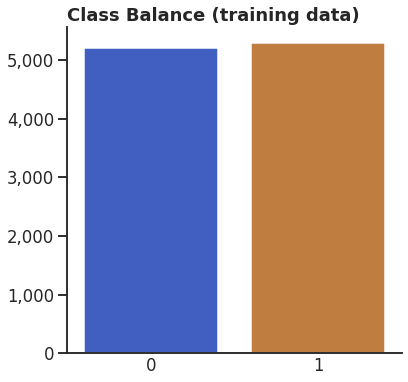

In [9]:
#hide_input
with sns.axes_style("ticks"):
    ax = sns.barplot(
        x="index",
        y=0,
        data=pd.Series(y_train).value_counts().reset_index(),
        saturation=0.5,
    )
    ax.set_title(
        "Class Balance (training data)",
        loc="left",
        fontweight="bold",
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.xaxis.set_tick_params(length=0)
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(6)
    fig.set_figwidth(6)

So, we don't need to re-balance the data before passing it to the Random Forest algorithm.

### Pre-Processing

We will assume that we are looking to interpret the importance of features used by these implementations. Note that our manually implemented version does not support this at the moment. To this end, we need to remove correlated features from the data.

Tree-based models are not sensitive to the scale of the features, but can be incorrect to interpret their contribution to the predictions if they are not all on the same scale (see [Strobel et al 2007](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-25)). So, the second pre-processing step we need is to standardize our data before it is used to train the Random Forest algorithm.

A heatmap of the feature-to-feature correlations is shown below

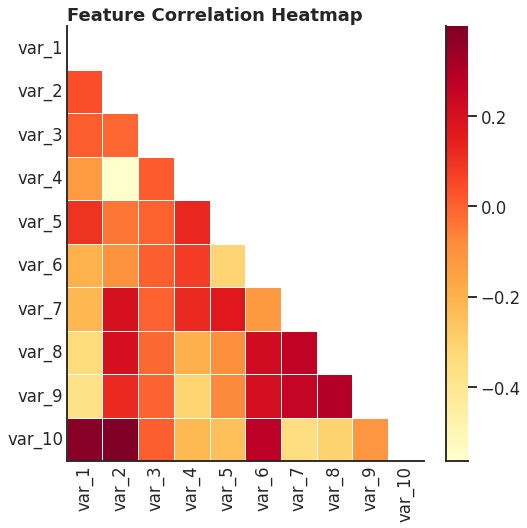

In [10]:
#hide_input
df_corr = pd.DataFrame(X_train, columns=list(df_X)).corr()
mask_ut = np.triu(np.ones(df_corr.shape)).astype(bool)

with sns.axes_style("ticks"):
    ax = sns.heatmap(
        data=df_corr,
        linewidths=0.5,
        cmap="YlOrRd",
        mask=mask_ut,
    )
    ax.set_title("Feature Correlation Heatmap", loc="left", fontweight="bold")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(8)

We'll remove correlated features based on this heatmap

In [11]:
cols_to_drop = ["var_1", "var_2", "var_6", "var_7"]
selected_cols = list(set(list(df_X)) - set(cols_to_drop))
X_train = pd.DataFrame(X_train, columns=list(df_X)).drop(columns=cols_to_drop).to_numpy()
X_test = pd.DataFrame(X_test, columns=list(df_X)).drop(columns=cols_to_drop).to_numpy()

### Comparing the Manual and Built-in Implementations of Random Forest

We'll define a pipeline to normalize the data before passing it to the manual implementation of the random forest algorithm

In [12]:
%%time
pipe_manual = Pipeline(
    [
        ("ss", MinMaxScaler()),
        ("reg", CustomRandomForestClassifier(5, 25, None, 100, 0.5)),
    ]
)
pipe_manual.fit(X_train, y_train)
y_pred_manual = pipe_manual.predict(X_test)

CPU times: user 6.22 s, sys: 133 ms, total: 6.35 s
Wall time: 6.45 s


We'll do the same with the built-in version of the algorithm

In [13]:
%%time
pipe_builtin = Pipeline(
    [
        ("ss", MinMaxScaler()),
        (
            "reg", RandomForestClassifier(
                min_samples_split=5,
                max_depth=25,
                max_features=None,
                n_estimators=100,
            )
        ),
    ]
)
pipe_builtin.fit(X_train, y_train)
y_pred_builtin = pipe_builtin.predict(X_test)

CPU times: user 4.43 s, sys: 0 ns, total: 4.43 s
Wall time: 4.43 s


Below are the first and last five rows of the testing data, along with the true and predicted labels found using the manually implemented and built-in Random Forest algorithms

In [14]:
#hide_input
df_pred_compare = pd.Series(y_pred_manual, name="manually_implemented_knn").to_frame().merge(
    pd.Series(y_pred_builtin, name="built_in_knn").to_frame(),
    left_index=True,
    right_index=True,
)
df_test_pred_compare = pd.DataFrame(X_test, columns=selected_cols).assign(true=y_test).merge(
    df_pred_compare,
    left_index=True,
    right_index=True,
)
display(
    df_test_pred_compare.head(5).append(df_test_pred_compare.tail(5))
    .style
    .format("{:.2f}", subset=selected_cols)
    .set_caption("First and Last 5 predictions of test split")
)

,var_9,var_10,var_3,var_5,var_4,var_8,true,manually_implemented_knn,built_in_knn
0,-0.32,1.47,0.45,2.12,-0.66,2.20,1,1,1
1,-0.10,1.15,2.16,1.42,0.12,0.01,0,0,0
2,-1.38,0.25,3.34,-1.41,-2.87,0.81,0,0,0
3,0.26,2.37,-0.70,-0.16,-0.70,2.61,1,1,1
4,-0.78,-0.66,-1.28,2.00,1.75,1.33,0,1,1
4495,0.28,1.25,0.90,0.14,2.00,-0.29,0,0,0
4496,-0.42,2.40,0.48,1.93,-1.59,-1.76,1,1,1
4497,0.17,3.98,-1.02,-0.32,-4.51,-0.65,1,1,1
4498,0.19,2.54,-0.26,-0.70,1.69,0.03,0,0,0
4499,-1.71,0.84,1.20,1.13,0.48,-0.06,0,1,1


In order to compare the performance of the two implementations, we'll show a cross-tabulation for their aggregated correct and incorrect predictions

In [15]:
#hide
labels = pd.Index([f"class_label={label}" for label in [0, 1]], name="Built-in")
df_cm = pd.DataFrame(
    confusion_matrix(y_pred_builtin, y_pred_manual), index=labels
).add_prefix("class_label=").rename_axis("Manual", axis=1)

df_ct = pd.crosstab(
    y_pred_builtin,
    y_pred_manual,
    rownames=["Built-in"],
    colnames=["Manual"],
).add_prefix("class_label=")
df_ct = df_ct.set_index("class_label="+df_ct.index.astype(str))
assert df_cm.equals(df_ct)

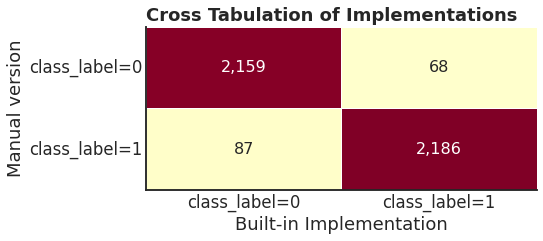

In [16]:
#hide_input
with sns.axes_style("ticks"):
    ax = sns.heatmap(
        data=df_cm,
        linewidths=0.5,
        cmap="YlOrRd",
        annot=True,
        fmt=",d",
        cbar=False,
        annot_kws={"size": 16},
    )
    ax.set_title(
        "Cross Tabulation of Implementations",
        loc="left",
        fontweight="bold",
    )
    ax.set_xlabel("Built-in Implementation")
    ax.set_ylabel("Manual version")
    sns.despine()
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)
    fig = plt.gcf()
    fig.set_figheight(3)
    fig.set_figwidth(7)

The built-in version was faster than the manually implemented version. A little less than 4 percent of the 4,500 predictions of the test dataset differ between the manually implemented and built-in versions of the algorithm. The off-diagonal entries (in light yellow) indicate the mismatches in predictions made by the two versions. This difference is likely to primarily be attributed to source of randomness in the algorithm.i.e. the drawing of a bootstrap sample. Although speed no doubt favours the built-in version, this would suggest that atleast the main functionality of the Random Forest algorithm has been replicated in our manual implementation here.

## Overview of Gradient Boosting

The goal of the gradient boosting algorithm is to iteratively learn how to make corrections for the previous mistakes it has made. It does this by training multiple decision trees (base learners) individually.

As the name suggests, it makes use of the gradient descent algorithm. In our manual implementation, we will aim to minimize the mean squared error (*MSE*) which is the squared difference between the true and predicted values of the dependent variable (or target, `y`). This is combined with boosting - the process of enhancing of the learning capability of a weak learner (single decision tree) by iteratively using multiple decision trees to produce a strong learner.

An overview of the working of this algorithm is as follows
1. Calculate an average of the target (dependent variable) of the training data. Consider this to be the initial prediction.
2. Calculate the residual between the training data target and the initial predictions.
3. Iterate over a pre-determined number of decision trees and train each tree on the training data with the residual as the target
   - during the first iteration, the residual between the initial guess for the prediction (the average) and the true training data target is taken as the residual
   - during subsequent iterations, it is the residual updated during the previous iteration that will be used here
4. Use the trained decision tree to predict the residual
5. Update the residual by subtracting this prediction from it
   - subtract the product of learning rate and the residual
     - the learning rate will determine how fast the residual is minimized during each iteration
     - a larger learning rate might overshoot the minimum but could reach there faster, while a smaller learning rate won't miss the minimum but will take longer to get there
6. Finally, append each trained decisoin tree to an empty list in order to build up a lilst of trained decision trees
7. Call each trained deciison tree to make a prediction of the test (unseen) data. Similar to training, multiply each prediction with the learning rate.
8. Finally, add up the predictions made by each trained decision tree (in the previous step) and add the initial guess (the average target value from the training data).

## Manual Implementation of Gradient Boosting

As we did with the custom `RandomForest` implementation, we will create a custom gradient boosting regressor class that will accept parameters for the maximum tree depth, number of decision trees that we want to use and the learning rate. The maximim depth will be passed to the individual weak learners that we train. As with the random forest implementation, additional hyperparameters could be passed on to the weak learners, for this implementation, but we'll just use the maximum tree depth. We will see how the learning rate will be used next. We're again inheriting from the `BaseEstimator` and `RegressorMixin` classes to make the class compatible with `scikit-learn`.

```python
class CustomGradientBoostingRegressor(BaseEstimator, TransformerMixin):
    def __init__(self, n_estimators=100, max_depth=10, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
```

As part of training this going to start by calculating the average of the target (dependent variable) from the training data. We'll also calculate the residual associated with this initial prediction by subtracting the prediction from the true target value. Note that this prediction and target value refer to an array of the training data and not to a single value. As mentioned above, this residual will be iteratively updated by each decision tree's predictions.

Next, we'll iterate over all the base learners (decision trees), train each on the training data but this time with the residual as the target. The trained decision tree is then used to predict the residual. This decision tree's prediction of the residual is then subtracted from the initial prediction of the residual - this is the process of updating the residual with each decision tree, eventually minimizing it. This is how the algorithm learns from its mistakes.

When updating the residuals, we will not just subtract the residual itself from the initial residual. Instead, we will subtract the product of the learning rate and the current tree's predicted residual. This is analogous to gradient descent. There, the gradient was updated in per iteration and needed to be minimized. Here, the residual is updated using the predictions of each trained base learner (or, each trained decision tree).

```python
def fit(self, X, y):
    # initial prediction
    self.y_pred_ = np.mean(y)

    # initial residual
    residuals_ = (y - self.y_pred_).tolist()

    # training base learners to minimize residual
    self.estimators_ = []
    for _ in range(self.n_estimators):
        # train
        tree_ = DecisionTreeRegressor(max_depth=self.max_depth)
        tree_.fit(X, residuals_)

        # update residual
        y_pred_train = tree_.predict(X)
        residuals_ = (
            np.array(residuals_) - (self.learning_rate * y_pred_train)
        ).tolist()

        # build-up list of trained base learners
        self.estimators_.append(tree_)
    return self
```

In order to make predictions on unseen data, we will add up the predictions produced by each trained estimator in the list. This is the same as the scaling of the each tree's prediction, using the learning rate, during training in the `.fit()` method. So far, we have just been working with the residual of the initial prediction (the constant, or average, prediction). It has been updated by iterating over each of the individual decision trees. So, we'll now add this constant (the average of the training data target) back to the final summed prediction to give our overall predictions for the test (unseen) data.

```python
@staticmethod
def single_estimator_prediction(X, learning_rate, estimator):
    """Make a prediction with a single trained decision tree."""
    return learning_rate * estimator.predict(X)


def predict(self, X):
    # Make predictions with each trained decision tree
    preds = [
        self.single_estimator_prediction(X, self.learning_rate, est)
        for est in self.estimators_
    ]

    # add up all predictions
    estimator_preds_ = np.sum(preds, axis=0)

    # add average prediction of target (from training data) to summed predictions
    y_pred_overall = estimator_preds_ + self.y_pred_
    return y_pred_overall
```

The final complete class to realize this implementation is shown below

In [17]:
class CustomGradientBoostingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, max_depth=10, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth


    def fit(self, X, y):
        # initial prediction
        self.y_pred_ = np.mean(y)

        # initial residual
        residuals_ = (y - self.y_pred_).tolist()

        # training base learners to minimize residual
        self.estimators_ = []
        for _ in range(self.n_estimators):
            # train
            tree_ = DecisionTreeRegressor(max_depth=self.max_depth)
            tree_.fit(X, residuals_)

            # update residual
            y_pred_train = tree_.predict(X)
            residuals_ = (
                np.array(residuals_) - (self.learning_rate * y_pred_train)
            ).tolist()

            # build-up list of trained base learners
            self.estimators_.append(tree_)
        return self


    @staticmethod
    def single_estimator_prediction(X, learning_rate, estimator):
        """Make a prediction with a single trained decision tree."""
        return learning_rate * estimator.predict(X)


    def predict(self, X):
        # Make predictions with each trained decision tree
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (
            delayed(self.single_estimator_prediction)(X, self.learning_rate, est)
            for est in self.estimators_
        )
        preds = executor(tasks)

        # add up all predictions
        estimator_preds_ = np.sum(preds, axis=0)

        # add average prediction of target (from training data) to summed predictions
        y_pred_overall = estimator_preds_ + self.y_pred_
        return y_pred_overall

A change is made to the `.predict()` method in order to parallelize predictions made with each trained decision tree. When summing these predictions, we don't need them to be in a particular order so we can parallelize their calls to make a prediction. This parallelization step is the same as what we did above with the Random Forest implementation.

## Using the custom gradient boosting implementation for regression

We can use the custom implementation to make predictions on a synthetic dataset. We can then compare these predictions to those made by the version of this algorithm built in to `scikit-learn`. To do this we'll generate a synthetic regression dataset of 20,000 rows and 25 features, of which 15 features will be useful for predicting the target

In [18]:
X, y = make_regression(
    n_samples=n_samples_gb,
    n_features=n_feats_gb,
    n_informative=n_informative_feats_gb,
    noise=noise_gb,
)
df_X = pd.DataFrame(X, columns=[f"var_{f_i}" for f_i in range(1, n_feats_gb+1)])
s_y = pd.Series(y, name="target")

Recall that the properties of this synthetic regression dataset were defined earlier

In [19]:
#hide_input
print(
    f"n_samples_gb = {n_samples_gb}, "
    f"n_feats_gb = {n_feats_gb}, "
    f"n_informative_feats_gb = {n_informative_feats_gb}, "
    f"noise_gb = {noise_gb}"
)

n_samples_gb = 20000, n_feats_gb = 25, n_informative_feats_gb = 15, noise_gb = 25


The first 5 rows of the generated dataset are shown below

In [20]:
#hide_input
display(
    df_X.head(5).assign(
        target=s_y.to_frame().head(5)
    ).style.set_caption(
        "First ten rows of independent (var_*) and dependent (target) variables in the data"
    )
)

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,target
0,-0.223011,0.179868,-0.154820,-2.227085,1.969173,-0.060686,-0.046739,0.784329,0.584825,0.234738,1.061733,-0.676085,-0.041723,1.634150,-0.216616,-1.597703,-1.098633,0.917189,0.014585,-1.157711,-0.891429,-0.795820,0.020996,-0.194969,-1.761135,-158.264365
1,-0.286999,0.593028,-0.473005,-1.165490,-1.229666,-0.091609,0.018704,2.236377,-0.286575,-1.425109,-0.228449,-0.184101,-2.728834,-0.276689,-0.383918,-0.508499,0.099501,-0.107763,0.041479,1.295804,-0.252423,-1.057466,-1.779850,-0.355574,-1.451316,-333.507854
2,-1.317927,0.283843,-0.934341,0.097839,-0.610285,-1.511026,0.167301,1.093614,-0.775090,-0.940465,-1.020371,-1.319924,1.272913,0.640726,-1.514854,-0.724081,-2.181743,1.216377,-0.026584,0.803912,0.658917,-0.906307,0.769189,-0.954964,-0.931621,-82.140421
3,1.052038,1.219628,0.472396,-1.559922,-2.413872,1.581726,-0.004788,0.147760,-0.969217,0.612192,-1.276852,-1.186855,-0.757354,-0.671043,-1.010746,0.443628,0.488247,-0.780966,1.066491,1.094533,-0.234753,-0.352541,-0.414543,-0.851234,1.088289,-241.280018
4,0.956539,0.105641,-1.879069,-0.902058,-0.103156,-0.494228,3.192277,1.894483,0.553269,0.163344,-0.254190,-1.358919,-1.150939,1.061961,-0.902114,-0.086117,0.288102,-0.512966,1.563868,0.878564,0.698072,-0.783779,0.982344,0.505974,-1.053844,396.099934


### Splitting the data

As with the Random Forest usage above, we will divide this synthetic dataset into a training and testing split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

### Pre-Processing

In order to explore correlation between features of the data, a heatmap of the feature-to-feature correlations is shown below

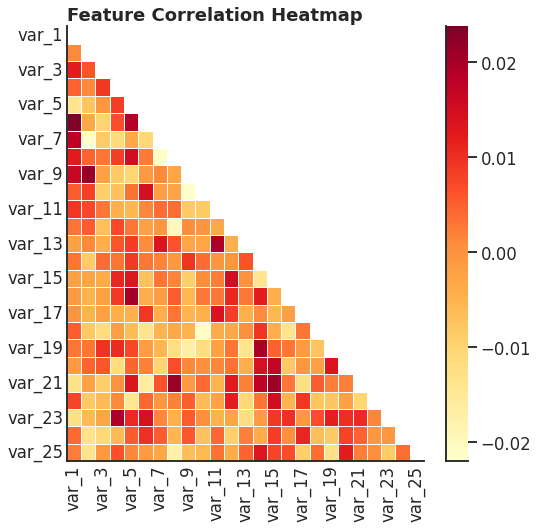

In [22]:
#hide_input
df_corr = pd.DataFrame(X_train, columns=list(df_X)).corr()
mask_ut = np.triu(np.ones(df_corr.shape)).astype(bool)

with sns.axes_style("ticks"):
    ax = sns.heatmap(
        data=df_corr,
        linewidths=0.5,
        cmap="YlOrRd",
        mask=mask_ut,
    )
    ax.set_title("Feature Correlation Heatmap", loc="left", fontweight="bold")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(8)

We'll assume we are looking to interpret the importance of features, even though our implementation does not currently support this, after predictions are made. So, we'll want to remove correlated features from this dataset before passing it to the gradient boosting algorithm. Luckily, our synthetic dataset doesn't have a problem of correlation between features.

Additionally, since tree-based models are not sensitive to the scale of the features, scaling of features to bring them onto the same scale is not required. However, using features on a different scale makes their interpretation difficult so we'll standardize all the features in the data.

### Comparison of Predictions to Built-in Implementation of Gradient Boosting

A two-step pipeline with standardization before applying our custom gradient boosting implementation is defined below and trained on our training dataset before making predictions on the test data

In [24]:
%%time
pipe_manual = Pipeline(
    [
        ("ss", StandardScaler()),
        ("reg", CustomGradientBoostingRegressor(250, 7, 0.05)),
    ]
)
pipe_manual.fit(X_train, y_train)
y_pred_manual = pipe_manual.predict(X_test)

CPU times: user 45.6 s, sys: 56.2 ms, total: 45.6 s
Wall time: 45.7 s


We now repeat the above step but this time we will use `scikit-learn`'s built-in gradient boosting implementation, with the same hyper-parameters as those that we used in our custom implementation

In [25]:
%%time
pipe_builtin = Pipeline(
    [
        ("ss", StandardScaler()),
        ("reg", GradientBoostingRegressor(n_estimators=250, max_depth=7, learning_rate=0.05)),
    ]
)
pipe_builtin.fit(X_train, y_train)
y_pred_builtin = pipe_builtin.predict(X_test)

CPU times: user 46.9 s, sys: 2.64 ms, total: 46.9 s
Wall time: 46.9 s


We'll now compare these two implementations in terms of their `R^2`, `MSE`, `RMSE` and `MAE` scores on the test set, by visualizing these metrics as a percent difference

In [26]:
#hide
d_scores = {
    "R^2__manual": r2_score(y_test, y_pred_manual),
    "R^2__built_in": r2_score(y_test, y_pred_builtin),
    "MSE__manual": mean_squared_error(y_test, y_pred_manual),
    "MSE__built_in": mean_squared_error(y_test, y_pred_builtin),
    "MAE__manual": mean_absolute_error(y_test, y_pred_manual),
    "MAE__built_in": mean_absolute_error(y_test, y_pred_builtin),
    "RMSE__manual": mean_squared_error(y_test, y_pred_manual, squared=False),
    "RMSE__built_in": mean_squared_error(y_test, y_pred_builtin, squared=False),
}
df_scores = pd.DataFrame.from_dict(
    d_scores, orient="index"
).reset_index().rename(columns={0: "OOS Score"})
df_scores[["metric", "algorithm"]] = df_scores["index"].str.split("__", expand=True)
df_scores[["metric", "algorithm"]] = df_scores[["metric", "algorithm"]].apply(
    lambda x: x.str.replace("_", "-"),
    axis=1
)
df_scores = df_scores.drop(columns=["index"])[["metric", "algorithm", "OOS Score"]]
display(
    df_scores.style.format("{:,.6f}", subset=["OOS Score"]).set_caption("Performance Comparison")
)

,metric,algorithm,OOS Score
0,R^2,manual,0.945695
1,R^2,built-in,0.945779
2,MSE,manual,"2,830.204951"
3,MSE,built-in,"2,825.830043"
4,MAE,manual,41.008540
5,MAE,built-in,41.011807
6,RMSE,manual,53.199671
7,RMSE,built-in,53.158537


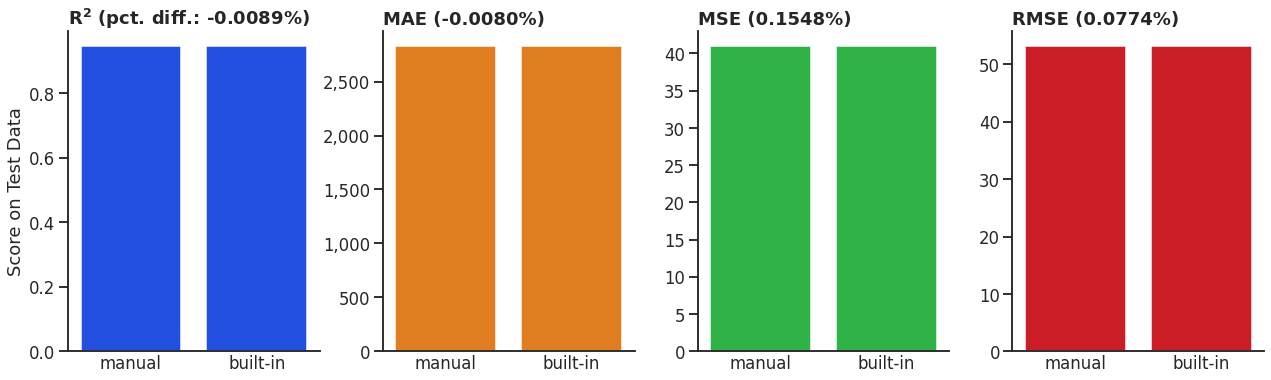

In [27]:
#hide_input
with sns.axes_style("ticks"):
    g = sns.FacetGrid(
        df_scores,
        col="metric",
        height=6,
        aspect=0.75,
        sharey=False,
        hue="metric",
        # palette="bright",
    )
    g.map(sns.barplot, "algorithm", "OOS Score", order=["manual", "built-in"])
    g.figure.subplots_adjust(wspace=0.25)
    titles = ["R^2", "MAE", "MSE", "RMSE"]
    for k, (ax, fig_title) in enumerate(zip(g.axes_dict.values(), titles)):
        pct_diff = (
            df_scores.query(f"metric == '{fig_title}'")
            .sort_values(by="algorithm")["OOS Score"]
            .pct_change().iloc[1] * 100
        )
        ax.set_xlabel(None)
        ax.set_title(None)
        title_suffix = "pct. diff.: " if fig_title == "R^2" else ""
        title = fig_title if fig_title not in ["R^2"] else "$\mathregular{R^2}$"
        ax.set_title(f"{title} ({title_suffix}{pct_diff:.4f}%)", fontweight="bold", loc="left")
        if fig_title not in ["R^2"]:
            ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
        else:
            ax.set_ylabel("Score on Test Data")
        ax.xaxis.set_tick_params(length=0)
    sns.despine()

or as a ratio to the built-in implementation

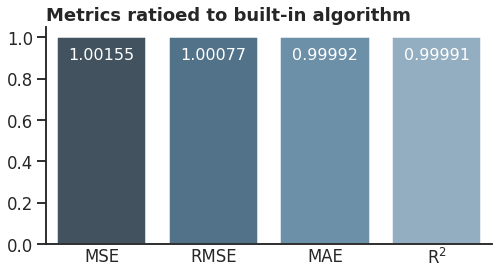

In [28]:
#hide_input
df_scores_ratio = (
    df_scores.groupby(["metric"], as_index=False)
    .apply(
        lambda r: r.sort_values(
            by=["algorithm"], ascending=False
        ).iloc[0]["OOS Score"] / r.iloc[1]["OOS Score"]
    )
    .rename(columns={None: "ratio to built-in"})
)
df_scores_ratio["metric"] = (
    df_scores_ratio["metric"].str.replace("R^2", "$\mathregular{R^2}$", regex=False)
)
df_scores_ratio = df_scores_ratio.sort_values(by="ratio to built-in", ascending=False)
palette = sns.color_palette('Blues_d', df_scores_ratio['metric'].nunique())

with sns.axes_style("ticks"):
    ax = sns.barplot(
        x="metric",
        y="ratio to built-in",
        data=df_scores_ratio,
        palette=np.array(palette)[::-1],
        saturation=0.5,
    )
    ax.set_title(
        "Metrics ratioed to built-in algorithm",
        loc="left",
        fontweight="bold",
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.xaxis.set_tick_params(length=0)
    ax.bar_label(ax.containers[0], fmt="%.5f", fontsize=16, padding=-25, color="white")
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(4)
    fig.set_figwidth(8)

For the plot of percent differences, the subplot titles show the percent difference in each scoring metric, calculated on the testing data, relative to the manual implementation. So, a percent difference of -0.2 percent would mean that the built-in implementation is 0.2 percent smaller relative to the manual implementation. Encouragingly, there appears to be good agreement between the two versions here.

Either plot of the metrics suggests our manual impementation has adequately captured the core principles of the algorithm.

Also, the two implementations took approximately the same time (in seconds) to run to completion. The built-in version performs several sanity checks on the data, unlike the manual implementation, so this preliminary agreement in execution timing with the manual approach points to its impressive performance.

## Summary and Additional Resources

We have implemented the core functionality of two decision tree-based ensembling algorithms for machine learning tasks. The ensembling method was unique for each algorithm but the outputs were in good aggreement with the implementations provided by the `scikit-learn` library.

Parallelization was provided for both algorithms' predictions. While the total duration (training and prediction combined) of the manual Gradient Boosting implementation was comparable to that of the version provided by `scikit-learn`, future work on the Random Forest implementation should focus on improving the end-to-end duration of the training.

The versions offered by `scikit-learn` expose hyper-parameters of individual decision trees than can also be adjusted beyond the small selection of these that our manual implementation has exposed to the user. In gradient boosting, it is possible to use a sample of the training data for training each weak learner, thus following stochastic gradient descent rather than the batch-based approach that we used here. Early stopping can also be done by setting aside a fraction of the training data as a validation split. The `scikit-learn` version of the Random Forest classifier allows for weights to be assigned to the classes, which is one viable approach to handle imbalanced data. In both techniques `scikit-learn` allows the splitting criterion for an individual decision tree (eg. `gini` for classification, `MSE` for regression) to be adjusted.

Information about additional ensembling techniques, and how they can be used in other machine learning tasks, is available here ([1](https://corporatefinanceinstitute.com/resources/knowledge/other/ensemble-methods/), [2](https://en.wikipedia.org/wiki/Ensemble_learning#Common_types_of_ensembles)).